In [1]:
from __future__ import division, absolute_import

import sys
import os
import numpy as np
import random
import pickle
import time

import h5py
import pandas as pd
from plotnine import *
from imblearn import over_sampling
from collections import Counter
from tables import *
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

import sklearn 
from sklearn import preprocessing
from sklearn.cluster import MiniBatchKMeans

#root
absPath = '/home/angela3/imbalance_pcm_benchmark/'
sys.path.insert(0, absPath)

from src.imbalance_functions import *

np.random.seed(8)
random.seed(8)

In [2]:
protein_type = "GPCRs" #"kinases"

In [3]:
activity_file = "".join((absPath, "data/", protein_type, "_activity.csv"))
activity_df = pd.read_csv(activity_file, sep="\t")
print(activity_df.info())
print(activity_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200523 entries, 0 to 200522
Data columns (total 10 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Unnamed: 0                200523 non-null  int64  
 1   DeepAffinity Protein ID   200523 non-null  object 
 2   Uniprot ID                200523 non-null  object 
 3   DeepAffinity Compound ID  200523 non-null  object 
 4   CID                       200523 non-null  int64  
 5   activity                  200523 non-null  float64
 6   label                     200523 non-null  float64
 7   Canonical SMILE           200523 non-null  object 
 8   Sequence                  200523 non-null  object 
 9   family                    200523 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 15.3+ MB
None
   Unnamed: 0 DeepAffinity Protein ID Uniprot ID DeepAffinity Compound ID  \
0          32                    UYMO     Q92847                     4vb

In [4]:
Counter(activity_df["label"])

Counter({1.0: 153993, 0.0: 46530})

In [5]:
unique_prots = activity_df["DeepAffinity Protein ID"].drop_duplicates().tolist()
print("There are",len(unique_prots),"different proteins")

There are 498 different proteins


In [6]:
if not os.path.exists("".join((absPath, "data/", protein_type, "/resampling_before_clustering/"))):
    os.makedirs("".join((absPath, "data/", protein_type, "/resampling_before_clustering/")))

In [7]:
with open("".join((absPath, "data/", protein_type, "/", protein_type, "_prots.pickle")), 'wb') as handle:
    pickle.dump(unique_prots, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
unique_comps = activity_df["DeepAffinity Compound ID"].drop_duplicates().tolist()
print("There are",len(unique_comps),"different compounds")

There are 120906 different compounds


In [9]:
activity_df.groupby(["DeepAffinity Protein ID", "label"])["label"].count()

DeepAffinity Protein ID  label
0048                     1.0       27
00NN                     1.0       54
00QN                     0.0       26
                         1.0      113
00RX                     0.0       16
                                 ... 
ZNRS                     0.0        2
ZONA                     0.0      247
                         1.0       64
ZQG1                     0.0        5
                         1.0       27
Name: label, Length: 895, dtype: int64

In [10]:
list_ratios = []
for prot in unique_prots:
    ratio_actives_inactives = computing_active_inactive_ratio(activity_df, prot)
    dicti = {"DeepAffinity Protein ID" : prot, "ratio_actives_inactives": ratio_actives_inactives}
    list_ratios.append(dicti)
    
df_ratios = pd.DataFrame(list_ratios)
df_ratios.head()

,DeepAffinity Protein ID,ratio_actives_inactives
0,UYMO,0.907371
1,0BJE,0.643026
2,78TA,0.681159
3,RJYX,0.580357
4,95E2,0.735330


/home/angela3/venv/lib/python3.6/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 12'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']), PlotnineWarning)


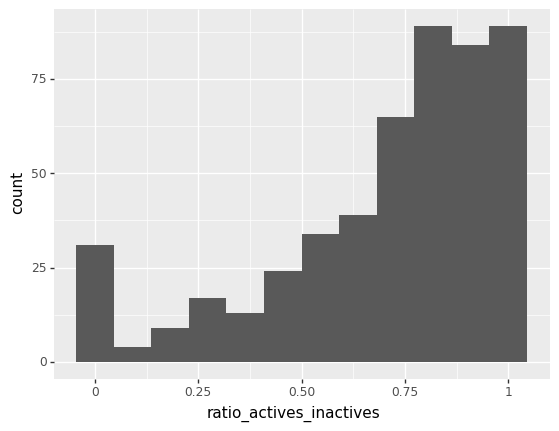

<ggplot: (8758897326870)>

In [11]:
(ggplot(df_ratios, aes("ratio_actives_inactives")) + geom_histogram())

In [12]:
# for each protein, save a sub-dataframe with the data
if not os.path.exists("".join((absPath, "data/", protein_type, "/resampling_before_clustering/subdataframes/"))):
    os.makedirs("".join((absPath, "data/", protein_type, "/resampling_before_clustering/subdataframes/")))

In [13]:
#loading fingeprints
file_fps = "".join((absPath,"raw_data/dcid_fingerprint.tsv" ))
fps_df = pd.read_csv(file_fps, sep="\t")
fps_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 598206 entries, 0 to 598205
Data columns (total 2 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   DeepAffinity Compound ID  598206 non-null  object
 1   Fingerprint Feature       598206 non-null  object
dtypes: object(2)
memory usage: 9.1+ MB


In [14]:
for prot in unique_prots:
    sub_prot = activity_df[activity_df["DeepAffinity Protein ID"] == prot]
    prot_fps = pd.merge(sub_prot[["DeepAffinity Protein ID", "DeepAffinity Compound ID", "label", 
                                  "Canonical SMILE", "Sequence", "family"]], 
                        fps_df, "left", on=["DeepAffinity Compound ID"])
        
    file_subdf = "".join((absPath, "data/", protein_type, "/resampling_before_clustering/subdataframes/", prot, ".csv"))
    prot_fps.to_csv(file_subdf)

In [15]:
# how many unique compounds are according to fingerprints?
activity_with_fps = pd.merge(activity_df, fps_df, "left", on=["DeepAffinity Compound ID"])
activity_with_fps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200523 entries, 0 to 200522
Data columns (total 11 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Unnamed: 0                200523 non-null  int64  
 1   DeepAffinity Protein ID   200523 non-null  object 
 2   Uniprot ID                200523 non-null  object 
 3   DeepAffinity Compound ID  200523 non-null  object 
 4   CID                       200523 non-null  int64  
 5   activity                  200523 non-null  float64
 6   label                     200523 non-null  float64
 7   Canonical SMILE           200523 non-null  object 
 8   Sequence                  200523 non-null  object 
 9   family                    200523 non-null  object 
 10  Fingerprint Feature       200523 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 18.4+ MB


In [16]:
activity_with_fps.drop_duplicates("Fingerprint Feature")

,Unnamed: 0,DeepAffinity Protein ID,Uniprot ID,DeepAffinity Compound ID,CID,activity,label,Canonical SMILE,Sequence,family,Fingerprint Feature
0,32,UYMO,Q92847,4vb9,11154001,7.251812,1.0,CC(C)NC(=O)NC1=CC=C(C=C1)C2=C(N=C(N=C2N)N)COCC...,MWNATPSEEPGFNLTLADLDWDASPGNDSLGDELLQLFPAPLLAGV...,GPCR,1110000001111011101100000000000000000000000000...
1,33,UYMO,Q92847,samf,11441554,8.154902,1.0,CC(C)(C)NC(=O)NC1=CC=C(C=C1)C2=C(N=C(N=C2N)N)C...,MWNATPSEEPGFNLTLADLDWDASPGNDSLGDELLQLFPAPLLAGV...,GPCR,1110000001111011101100000000000000000000000000...
2,34,UYMO,Q92847,fckm,11442040,7.055517,1.0,C1=CC=C(C=C1)COCC2=C(C(=NC(=N2)N)N)C3=CC=C(C=C...,MWNATPSEEPGFNLTLADLDWDASPGNDSLGDELLQLFPAPLLAGV...,GPCR,1110000001111011101100000000000000000000000000...
3,35,UYMO,Q92847,e68w,11248021,7.468521,1.0,C1=CC=C(C=C1)CNC(=O)NC2=CC=C(C=C2)C3=C(N=C(N=C...,MWNATPSEEPGFNLTLADLDWDASPGNDSLGDELLQLFPAPLLAGV...,GPCR,1110000001111011101100000000000000000000000000...
4,36,UYMO,Q92847,ob5k,11351838,8.000000,1.0,CC(C1=CC=CC=C1)NC(=O)NC2=CC=C(C=C2)C3=C(N=C(N=...,MWNATPSEEPGFNLTLADLDWDASPGNDSLGDELLQLFPAPLLAGV...,GPCR,1110000001111011101100000000000000000000000000...
...,...,...,...,...,...,...,...,...,...,...,...
200438,827923,XFGZ,Q62035,farx,44353152,5.004365,0.0,CC1C(=O)OC2C1(C3C(=O)OC4C3(C2)C5(C(C4O)C(C)(C)...,MEHNGSFRVDSEFRYTLFPIVYSVIFILGVVANGYVLWVFANLYPS...,GPCR,1110000001111000001111000000000000000000000000...
200439,827924,XFGZ,Q62035,l3sk,44353135,6.823909,1.0,CC1C(=O)OC2C1(C34C(=O)OC5C3(C2O)C6(C(C5)C(C)(C...,MEHNGSFRVDSEFRYTLFPIVYSVIFILGVVANGYVLWVFANLYPS...,GPCR,1110000001111011001111011000000000000000000000...
200440,827925,XFGZ,Q62035,wexm,44353151,6.251812,1.0,CC1C(=O)OC2C1(C3C(=O)OC4C3(C2O)C5(C(C4)C(C)(C)...,MEHNGSFRVDSEFRYTLFPIVYSVIFILGVVANGYVLWVFANLYPS...,GPCR,1110000001111000001111000000000000000000000000...
200441,827926,XFGZ,Q62035,0szf,44353099,6.236572,1.0,CC1C(=O)OC2C1(C34C(=O)OC5C3(C2O)C6(C(C5O)C(C)(...,MEHNGSFRVDSEFRYTLFPIVYSVIFILGVVANGYVLWVFANLYPS...,GPCR,1111000001111100001111000000000000000000000000...


In [17]:
activity_with_fps.drop_duplicates("DeepAffinity Compound ID")

,Unnamed: 0,DeepAffinity Protein ID,Uniprot ID,DeepAffinity Compound ID,CID,activity,label,Canonical SMILE,Sequence,family,Fingerprint Feature
0,32,UYMO,Q92847,4vb9,11154001,7.251812,1.0,CC(C)NC(=O)NC1=CC=C(C=C1)C2=C(N=C(N=C2N)N)COCC...,MWNATPSEEPGFNLTLADLDWDASPGNDSLGDELLQLFPAPLLAGV...,GPCR,1110000001111011101100000000000000000000000000...
1,33,UYMO,Q92847,samf,11441554,8.154902,1.0,CC(C)(C)NC(=O)NC1=CC=C(C=C1)C2=C(N=C(N=C2N)N)C...,MWNATPSEEPGFNLTLADLDWDASPGNDSLGDELLQLFPAPLLAGV...,GPCR,1110000001111011101100000000000000000000000000...
2,34,UYMO,Q92847,fckm,11442040,7.055517,1.0,C1=CC=C(C=C1)COCC2=C(C(=NC(=N2)N)N)C3=CC=C(C=C...,MWNATPSEEPGFNLTLADLDWDASPGNDSLGDELLQLFPAPLLAGV...,GPCR,1110000001111011101100000000000000000000000000...
3,35,UYMO,Q92847,e68w,11248021,7.468521,1.0,C1=CC=C(C=C1)CNC(=O)NC2=CC=C(C=C2)C3=C(N=C(N=C...,MWNATPSEEPGFNLTLADLDWDASPGNDSLGDELLQLFPAPLLAGV...,GPCR,1110000001111011101100000000000000000000000000...
4,36,UYMO,Q92847,ob5k,11351838,8.000000,1.0,CC(C1=CC=CC=C1)NC(=O)NC2=CC=C(C=C2)C3=C(N=C(N=...,MWNATPSEEPGFNLTLADLDWDASPGNDSLGDELLQLFPAPLLAGV...,GPCR,1110000001111011101100000000000000000000000000...
...,...,...,...,...,...,...,...,...,...,...,...
200444,827929,XFGZ,Q62035,5jma,44353072,6.327902,1.0,CC1C(=O)OC2C1(C34C(=O)OC5C3(C2O)C6(C(C5O)C(C)(...,MEHNGSFRVDSEFRYTLFPIVYSVIFILGVVANGYVLWVFANLYPS...,GPCR,1110000001111011001111011000000000000000000000...
200445,827930,XFGZ,Q62035,puon,44353145,7.045757,1.0,CC1C(=O)OC2C1(C34C(=O)OC5C3(C2O)C6(C(C5)C(C)(C...,MEHNGSFRVDSEFRYTLFPIVYSVIFILGVVANGYVLWVFANLYPS...,GPCR,1110000001111011001111011100000000000000000000...
200446,827931,XFGZ,Q62035,veaf,44353034,5.835647,0.0,CC1C(=O)OC2C1(C3C(=O)OC4C3(C2)C5(C(C4)C(C)(C)C...,MEHNGSFRVDSEFRYTLFPIVYSVIFILGVVANGYVLWVFANLYPS...,GPCR,1110000001111000001111000000000000000000000000...
200447,827932,XFGZ,Q62035,tsx8,44353073,6.886057,1.0,CC1C(=O)OC2C1(C34C(=O)OC5C3(C2O)C6(C(C5)C(C)(C...,MEHNGSFRVDSEFRYTLFPIVYSVIFILGVVANGYVLWVFANLYPS...,GPCR,1111000001111100001111000000000000000000000000...


### Balancing data 

In [22]:
for prot in unique_prots:
    print(prot)    
    file_subdf = "".join((absPath, "data/", protein_type, "/resampling_before_clustering/subdataframes/", prot, ".csv"))
    sub_prot = pd.read_csv(file_subdf)
    print(sub_prot.shape)

UYMO
(1004, 8)
0BJE
(423, 8)
78TA
(138, 8)
RJYX
(112, 8)
95E2
(2471, 8)
P59Q
(980, 8)
XY2A
(261, 8)
3Y9A
(771, 8)
J6QF
(1360, 8)
I8AL
(3734, 8)
K1O5
(4050, 8)
Q6RX
(5672, 8)
L3MG
(121, 8)
5W5R
(3647, 8)
3KD1
(224, 8)
MUMW
(279, 8)
SH36
(286, 8)
2CH1
(487, 8)
TOAR
(580, 8)
F5KQ
(1125, 8)
N0SR
(307, 8)
230E
(352, 8)
OYY9
(498, 8)
7WTN
(20, 8)
8VB1
(132, 8)
CVFR
(91, 8)
LETU
(699, 8)
LFAB
(79, 8)
C0XK
(188, 8)
DFO0
(3369, 8)
1ZXI
(338, 8)
SXV6
(5118, 8)
DPHN
(2338, 8)
ZALS
(223, 8)
Y9QF
(2698, 8)
YO6L
(3241, 8)
3Y7S
(181, 8)
5GL1
(115, 8)
NXHT
(233, 8)
JVOZ
(32, 8)
4C54
(174, 8)
06WU
(238, 8)
662N
(1017, 8)
ES23
(1951, 8)
KPOO
(36, 8)
DFF0
(1077, 8)
CFPC
(593, 8)
SPT7
(741, 8)
HSYO
(669, 8)
FESF
(223, 8)
FFXN
(1638, 8)
1AZF
(1212, 8)
5N4X
(3347, 8)
G8ER
(1074, 8)
SG15
(1411, 8)
2SAM
(892, 8)
8PJC
(17, 8)
TBTI
(3694, 8)
4BF3
(189, 8)
DCP7
(36, 8)
XTZC
(954, 8)
VX88
(886, 8)
V31H
(34, 8)
8ZJZ
(350, 8)
OG3W
(338, 8)
33X9
(274, 8)
69Q1
(610, 8)
SVAL
(4463, 8)
OBT5
(671, 8)
3QL2
(221, 8)
7V1X


In [24]:
prots_passing_smote = []

for prot in unique_prots:
    print(prot)
    sm = over_sampling.SMOTE(sampling_strategy=1.0, random_state=42)
    
    file_subdf = "".join((absPath, "data/", protein_type, "/resampling_before_clustering/subdataframes/", prot, ".csv"))
    sub_prot = pd.read_csv(file_subdf)
    
    sub_prot["separated_fps"] = sub_prot["Fingerprint Feature"].apply(separating_fps)
    X = pd.DataFrame.from_dict(dict(zip(sub_prot["separated_fps"].index, sub_prot["separated_fps"].values))).transpose()
    Y = sub_prot["label"].values
    print(X.shape)
    try:
        Xmot, Ymot = sm.fit_resample(X, Y)
        print(Xmot.shape)
        prots_passing_smote.append(prot)
    except:
        print(" The specified ratio required to remove samples from the minority class while trying to generate new samples.")
        continue
    #print(Counter(Ymot))
    # para cada proteina, guardar un sub-dataframe con los datos
    if not os.path.exists("".join((absPath, "data/", protein_type, "/resampling_before_clustering/resampled_data/"))):
        os.makedirs("".join((absPath, "data/", protein_type, "/resampling_before_clustering/resampled_data/")))
        
    pickle_path = "".join((absPath, "data/", protein_type, "/resampling_before_clustering/resampled_data/", prot, ".pickle"))
    with open(pickle_path, 'wb') as handle:
        pickle.dump((Xmot, Ymot), handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("There are", len(prots_passing_smote), "proteins to which SMOTE can be applied")

UYMO
(1004, 881)
(1822, 881)
0BJE
(423, 881)
(544, 881)
78TA
(138, 881)
(188, 881)
RJYX
(112, 881)
(130, 881)
95E2
(2471, 881)
(3634, 881)
P59Q
(980, 881)
(988, 881)
XY2A
(261, 881)
(464, 881)
3Y9A
(771, 881)
(1102, 881)
J6QF
(1360, 881)
(1888, 881)
I8AL
(3734, 881)
(5412, 881)
K1O5
(4050, 881)
(6180, 881)
Q6RX
(5672, 881)
(9160, 881)
L3MG
(121, 881)
(222, 881)
5W5R
(3647, 881)
(5746, 881)
3KD1
(224, 881)
(242, 881)
MUMW
(279, 881)
(452, 881)
SH36
(286, 881)
(386, 881)
2CH1
(487, 881)
(864, 881)
TOAR
(580, 881)
(994, 881)
F5KQ
(1125, 881)
(1884, 881)
N0SR
(307, 881)
(440, 881)
230E
(352, 881)
(530, 881)
OYY9
(498, 881)
(846, 881)
7WTN
(20, 881)
 The specified ratio required to remove samples from the minority class while trying to generate new samples.
8VB1
(132, 881)
(186, 881)
CVFR
(91, 881)
(170, 881)
LETU
(699, 881)
(1044, 881)
LFAB
(79, 881)
(96, 881)
C0XK
(188, 881)
(272, 881)
DFO0
(3369, 881)
(5946, 881)
1ZXI
(338, 881)
(384, 881)
SXV6
(5118, 881)
(8066, 881)
DPHN
(2338, 881)
(3

(38, 881)
WQ3A
(9, 881)
 The specified ratio required to remove samples from the minority class while trying to generate new samples.
DNWK
(515, 881)
(690, 881)
NTUT
(205, 881)
 The specified ratio required to remove samples from the minority class while trying to generate new samples.
3Z8F
(3272, 881)
(5844, 881)
TFJZ
(52, 881)
(72, 881)
DJ5R
(496, 881)
(602, 881)
00RX
(35, 881)
(38, 881)
0HD3
(24, 881)
 The specified ratio required to remove samples from the minority class while trying to generate new samples.
1HM4
(916, 881)
(1400, 881)
PNO7
(2947, 881)
(5482, 881)
O7ZO
(153, 881)
(232, 881)
Q629
(206, 881)
(210, 881)
3QPC
(107, 881)
(126, 881)
ZILL
(149, 881)
(190, 881)
TNWO
(197, 881)
(364, 881)
ZONA
(311, 881)
(494, 881)
I9GA
(76, 881)
(102, 881)
UYUW
(121, 881)
(130, 881)
5BY2
(122, 881)
(136, 881)
4ZSS
(94, 881)
(134, 881)
RANQ
(22, 881)
 The specified ratio required to remove samples from the minority class while trying to generate new samples.
MT2Z
(34, 881)
 The specified ra

(106, 881)
RF4S
(1, 881)
 The specified ratio required to remove samples from the minority class while trying to generate new samples.
5ZH2
(9, 881)
 The specified ratio required to remove samples from the minority class while trying to generate new samples.
CNF3
(1, 881)
 The specified ratio required to remove samples from the minority class while trying to generate new samples.
DDIO
(1, 881)
 The specified ratio required to remove samples from the minority class while trying to generate new samples.
OO26
(3, 881)
 The specified ratio required to remove samples from the minority class while trying to generate new samples.
TSAP
(32, 881)
(50, 881)
L5ZE
(17, 881)
(18, 881)
UWXL
(110, 881)
 The specified ratio required to remove samples from the minority class while trying to generate new samples.
E9GT
(13, 881)
 The specified ratio required to remove samples from the minority class while trying to generate new samples.
TIRU
(7, 881)
 The specified ratio required to remove samples from t

(170, 881)
KMYX
(1, 881)
 The specified ratio required to remove samples from the minority class while trying to generate new samples.
JW3C
(1, 881)
 The specified ratio required to remove samples from the minority class while trying to generate new samples.
9RML
(3, 881)
 The specified ratio required to remove samples from the minority class while trying to generate new samples.
0048
(27, 881)
 The specified ratio required to remove samples from the minority class while trying to generate new samples.
GRNT
(5, 881)
 The specified ratio required to remove samples from the minority class while trying to generate new samples.
XRDN
(54, 881)
 The specified ratio required to remove samples from the minority class while trying to generate new samples.
1XAL
(64, 881)
(82, 881)
30AY
(1, 881)
 The specified ratio required to remove samples from the minority class while trying to generate new samples.
OBNN
(1, 881)
 The specified ratio required to remove samples from the minority class while tr

In [26]:
#with open("".join((absPath, "data/", protein_type, "/smote_prots.pickle")), 'wb') as handle:
#    pickle.dump(prots_passing_smote, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [27]:
df_lists = []
for prot in prots_passing_smote:
    print(prot)
    #Load data pickle
    pickle_path = "".join((absPath, "data/", protein_type, "/resampling_before_clustering/resampled_data/", prot, ".pickle"))
    with open(pickle_path, 'rb') as handle:
        Xmot, Ymot = pickle.load(handle)
    df = Xmot.copy()
    df["Y"] = Ymot
    print(len(Ymot))
    df["prot"] = prot
    df_lists.append(df)
    
df_complete = pd.concat(df_lists)

UYMO
1822
0BJE
544
78TA
188
RJYX
130
95E2
3634
P59Q
988
XY2A
464
3Y9A
1102
J6QF
1888
I8AL
5412
K1O5
6180
Q6RX
9160
L3MG
222
5W5R
5746
3KD1
242
MUMW
452
SH36
386
2CH1
864
TOAR
994
F5KQ
1884
N0SR
440
230E
530
OYY9
846
8VB1
186
CVFR
170
LETU
1044
LFAB
96
C0XK
272
DFO0
5946
1ZXI
384
SXV6
8066
DPHN
3704
ZALS
428
Y9QF
4720
YO6L
5624
3Y7S
288
5GL1
190
NXHT
272
JVOZ
40
4C54
260
06WU
260
662N
1802
ES23
3286
DFF0
1740
CFPC
882
SPT7
916
HSYO
1260
FESF
318
FFXN
2692
1AZF
2190
5N4X
5718
G8ER
1656
SG15
2370
2SAM
1548
TBTI
5688
4BF3
352
DCP7
46
XTZC
1588
VX88
1572
V31H
44
8ZJZ
546
OG3W
642
33X9
392
69Q1
1028
SVAL
6688
OBT5
740
3QL2
428
7V1X
4358
1MWP
490
IAKH
758
FFCA
3696
4SAW
80
ZG4W
464
9FAD
870
K90C
366
CJWT
1026
LTX5
102
V27B
292
QZ2G
52
RPPN
2882
C0L6
228
5K6Y
2102
IE5U
632
YVNY
342
3WO1
5546
S982
4712
YT4M
544
DLLJ
614
MAYC
1030
79FS
3184
BDHY
172
SKZW
4958
8L6X
270
5NBB
76
00QN
226
WP5M
818
L0SK
4970
JC99
328
7ODP
848
MQ2W
340
BYDL
158
MJPC
162
MXWS
56
8XDT
358
UAIV
758
29H1
578
N5CC
2418
5BQ

In [28]:
df_complete["fingerprint"] = df_complete[[i for i in range(881)]].apply(lambda row: "".join(row.values.astype(str)), axis=1)
df_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307912 entries, 0 to 19
Columns: 884 entries, 0 to fingerprint
dtypes: float64(1), int64(881), object(2)
memory usage: 2.0+ GB


In [29]:
df_complete.head()

,0,1,2,3,4,5,6,7,8,9,...,874,875,876,877,878,879,880,Y,prot,fingerprint
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1.0,UYMO,1110000001111011101100000000000000000000000000...
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1.0,UYMO,1110000001111011101100000000000000000000000000...
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1.0,UYMO,1110000001111011101100000000000000000000000000...
3,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1.0,UYMO,1110000001111011101100000000000000000000000000...
4,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1.0,UYMO,1110000001111011101100000000000000000000000000...


In [30]:
unique_compounds_df = df_complete.drop_duplicates(subset="fingerprint", keep="first", ignore_index=True)
unique_compounds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133861 entries, 0 to 133860
Columns: 884 entries, 0 to fingerprint
dtypes: float64(1), int64(881), object(2)
memory usage: 902.8+ MB


In [31]:
names_comps = ["c"+str(i) for i in range(unique_compounds_df.shape[0])]
unique_compounds_df["comp_ID"] = names_comps
unique_compounds_df.head()

/home/angela3/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,0,1,2,3,4,5,6,7,8,9,...,875,876,877,878,879,880,Y,prot,fingerprint,comp_ID
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1.0,UYMO,1110000001111011101100000000000000000000000000...,c0
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1.0,UYMO,1110000001111011101100000000000000000000000000...,c1
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1.0,UYMO,1110000001111011101100000000000000000000000000...,c2
3,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1.0,UYMO,1110000001111011101100000000000000000000000000...,c3
4,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1.0,UYMO,1110000001111011101100000000000000000000000000...,c4


In [32]:
unique_compounds_df[["fingerprint", "comp_ID"]].to_csv("".join((absPath, "data/", protein_type, 
                                                               "/resampling_before_clustering/unique_compounds.csv")))

### Clustering data

In [33]:
nclusters = 100
batch_size = 1000

sample_indices = np.arange(0, unique_compounds_df.shape[0])
sample_indices = np.random.permutation(sample_indices)

In [34]:
#double checking
compounds_df_filtered = unique_compounds_df.drop(["prot", "Y"], axis=1)#[["fingerprint", "comp_ID"]]
print(compounds_df_filtered.head())
print(compounds_df_filtered.info())

   0  1  2  3  4  5  6  7  8  9  ...  873  874  875  876  877  878  879  880  \
0  1  1  1  0  0  0  0  0  0  1  ...    0    0    0    0    0    0    0    0   
1  1  1  1  0  0  0  0  0  0  1  ...    0    0    0    0    0    0    0    0   
2  1  1  1  0  0  0  0  0  0  1  ...    0    0    0    0    0    0    0    0   
3  1  1  1  0  0  0  0  0  0  1  ...    0    0    0    0    0    0    0    0   
4  1  1  1  0  0  0  0  0  0  1  ...    0    0    0    0    0    0    0    0   

                                         fingerprint  comp_ID  
0  1110000001111011101100000000000000000000000000...       c0  
1  1110000001111011101100000000000000000000000000...       c1  
2  1110000001111011101100000000000000000000000000...       c2  
3  1110000001111011101100000000000000000000000000...       c3  
4  1110000001111011101100000000000000000000000000...       c4  

[5 rows x 883 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133861 entries, 0 to 133860
Columns: 883 entries, 0 to comp_I

In [35]:
generate_batches = batch_generator(batch_size, compounds_df_filtered, sample_indices)

In [36]:
#K-Means
model = MiniBatchKMeans(n_clusters=nclusters, init='k-means++', compute_labels=True)
sse = {}
labels = []
comp_ids = []
clusters_centers = {}
#i=0
for i, batch in enumerate(generate_batches):
    print("Iteration ", i)
    t0 = time.time()
    df = pd.DataFrame(batch)
    print(df["comp_ID"])
    comp_ids.append(df["comp_ID"])
    to_array = df.drop(['comp_ID'], axis=1).values
    to_array = preprocessing.scale(to_array)
    
    model.partial_fit(to_array)
    print("The inertia for the batch %s is %s" % (i, model.inertia_))
    t_mini_batch = time.time() - t0
    print(t_mini_batch)
    sse[i] = model.inertia_
    labels.append(model.labels_)
    clusters_centers[i] = model.cluster_centers_

Iteration  0
0       c74269
1       c28583
2       c35164
3      c100690
4       c83310
        ...   
995     c33771
996     c61959
997    c131516
998    c121628
999     c68462
Name: comp_ID, Length: 1000, dtype: object
The inertia for the batch 0 is 292476.33252450125
0.6187167167663574
Iteration  1
0       c11150
1       c49573
2       c36332
3       c99375
4      c126626
        ...   
995     c19834
996    c113116
997     c54755
998     c41189
999    c108808
Name: comp_ID, Length: 1000, dtype: object
The inertia for the batch 1 is 363122.8197571262
0.3761255741119385
Iteration  2
0      c131498
1       c47027
2      c120415
3       c25350
4       c14236
        ...   
995     c43888
996     c99509
997    c109472
998     c85190
999     c44022
Name: comp_ID, Length: 1000, dtype: object
The inertia for the batch 2 is 354647.4114199112
0.41675782203674316
Iteration  3
0       c86886
1          c79
2        c9381
3        c2148
4        c1235
        ...   
995      c9043
996      c843

Iteration  29
0       c70828
1      c114216
2       c60619
3      c115922
4       c58328
        ...   
995    c112272
996     c89818
997     c86017
998     c79913
999    c108474
Name: comp_ID, Length: 1000, dtype: object
The inertia for the batch 29 is 359427.75656733726
0.40297365188598633
Iteration  30
0       c13404
1       c33975
2       c69934
3      c109048
4      c104824
        ...   
995      c2878
996      c1890
997     c56304
998    c110041
999     c83788
Name: comp_ID, Length: 1000, dtype: object
The inertia for the batch 30 is 360667.6484084274
0.3119385242462158
Iteration  31
0      c111725
1         c410
2       c65106
3      c132222
4       c83086
        ...   
995     c20112
996     c60336
997    c104243
998     c69171
999     c77848
Name: comp_ID, Length: 1000, dtype: object
The inertia for the batch 31 is 352025.28307622054
0.38054347038269043
Iteration  32
0        c5329
1        c3077
2      c116483
3       c52582
4        c5410
        ...   
995     c47531
996 

Iteration  58
0       c31202
1       c95001
2      c118784
3      c103091
4      c119719
        ...   
995     c95269
996    c119471
997    c131203
998    c130717
999     c17772
Name: comp_ID, Length: 1000, dtype: object
The inertia for the batch 58 is 363592.0981398363
0.36072349548339844
Iteration  59
0       c25765
1       c71382
2       c25361
3       c44285
4       c73266
        ...   
995     c91928
996      c9544
997     c33028
998    c124762
999     c98632
Name: comp_ID, Length: 1000, dtype: object
The inertia for the batch 59 is 360045.81911585724
0.35812878608703613
Iteration  60
0      c124800
1       c80029
2       c38533
3      c120216
4       c98517
        ...   
995     c99033
996     c62596
997     c51640
998     c80797
999    c132387
Name: comp_ID, Length: 1000, dtype: object
The inertia for the batch 60 is 351119.583289226
0.3749113082885742
Iteration  61
0      c133833
1       c22579
2      c119131
3       c47500
4       c56416
        ...   
995    c126082
996   

Iteration  87
0       c25991
1       c59444
2       c57900
3       c89629
4      c124141
        ...   
995     c66013
996    c107920
997     c51834
998     c38350
999     c46209
Name: comp_ID, Length: 1000, dtype: object
The inertia for the batch 87 is 355577.5171695543
0.37030911445617676
Iteration  88
0       c17605
1      c106699
2       c64367
3       c35927
4       c84615
        ...   
995     c43137
996      c2179
997     c57190
998    c104352
999      c3811
Name: comp_ID, Length: 1000, dtype: object
The inertia for the batch 88 is 359652.40918531525
0.4100501537322998
Iteration  89
0       c65803
1      c103364
2       c50925
3       c87942
4       c21248
        ...   
995     c40263
996     c70793
997     c67152
998      c9431
999     c51871
Name: comp_ID, Length: 1000, dtype: object
The inertia for the batch 89 is 344721.45772249135
0.4466874599456787
Iteration  90
0      c129441
1       c28596
2       c47943
3       c31715
4      c100641
        ...   
995     c77610
996  

Iteration  115
0      c106677
1      c100932
2       c90887
3       c53493
4      c126956
        ...   
995     c53037
996      c8462
997     c66924
998     c82503
999    c118437
Name: comp_ID, Length: 1000, dtype: object
The inertia for the batch 115 is 361240.04055894393
0.37072205543518066
Iteration  116
0       c62498
1       c56216
2      c119276
3       c80379
4       c61027
        ...   
995     c82366
996    c128497
997     c32250
998    c121667
999     c99179
Name: comp_ID, Length: 1000, dtype: object
The inertia for the batch 116 is 356239.02258615487
0.3655869960784912
Iteration  117
0       c86012
1      c104231
2       c83914
3      c113994
4       c41773
        ...   
995     c77886
996    c133174
997      c4102
998     c98365
999    c120163
Name: comp_ID, Length: 1000, dtype: object
The inertia for the batch 117 is 354604.7223242509
0.33745861053466797
Iteration  118
0        c8540
1       c37969
2       c46021
3       c16873
4       c31028
        ...   
995     c372

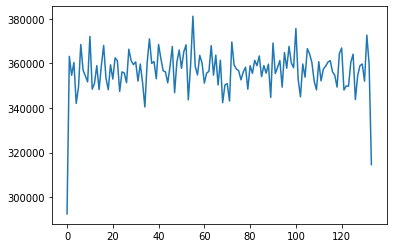

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133861 entries, 0 to 133860
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   comp_ID        133861 non-null  object
 1   cluster_label  133861 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 1.5+ MB


In [37]:
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.show()

labels_array = np.hstack(labels)
comp_ids_list = np.hstack(comp_ids)

#Joining compound IDs and cluster labels
compound_clusters = pd.DataFrame({'comp_ID':comp_ids_list,
                                  'cluster_label':labels_array})

compound_clusters.info()

In [38]:
compound_clusters.to_csv("".join((absPath, "data/", protein_type, 
                                "/resampling_before_clustering/compound_clusters.csv")), header=True)

In [39]:
compounds_df_filtered["fingerprint"] = compounds_df_filtered[[i for i in range(881)]].apply(lambda row: "".join(row.values.astype(str)), axis=1)
compounds_df_filtered.head()

,0,1,2,3,4,5,6,7,8,9,...,873,874,875,876,877,878,879,880,fingerprint,comp_ID
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1110000001111011101100000000000000000000000000...,c0
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1110000001111011101100000000000000000000000000...,c1
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1110000001111011101100000000000000000000000000...,c2
3,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1110000001111011101100000000000000000000000000...,c3
4,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1110000001111011101100000000000000000000000000...,c4


In [40]:
#merging compound names, compound clusters and fingerprints
activity_with_IDs = pd.merge(df_complete[["prot", "Y", "fingerprint"]], 
                                 compounds_df_filtered, 
                                on=["fingerprint"], how='left')
activity_with_IDs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307912 entries, 0 to 307911
Columns: 885 entries, prot to comp_ID
dtypes: float64(1), int64(881), object(3)
memory usage: 2.0+ GB


In [41]:
activity_with_IDs.head()

,prot,Y,fingerprint,0,1,2,3,4,5,6,...,872,873,874,875,876,877,878,879,880,comp_ID
0,UYMO,1.0,1110000001111011101100000000000000000000000000...,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,c0
1,UYMO,1.0,1110000001111011101100000000000000000000000000...,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,c1
2,UYMO,1.0,1110000001111011101100000000000000000000000000...,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,c2
3,UYMO,1.0,1110000001111011101100000000000000000000000000...,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,c3
4,UYMO,1.0,1110000001111011101100000000000000000000000000...,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,c4


In [42]:
activity_df_clusters = pd.merge(activity_with_IDs, compound_clusters, on=["comp_ID"], how="left")
activity_df_clusters.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307912 entries, 0 to 307911
Columns: 886 entries, prot to cluster_label
dtypes: float64(1), int32(1), int64(881), object(3)
memory usage: 2.0+ GB


In [43]:
activity_df_clusters.head()

,prot,Y,fingerprint,0,1,2,3,4,5,6,...,873,874,875,876,877,878,879,880,comp_ID,cluster_label
0,UYMO,1.0,1110000001111011101100000000000000000000000000...,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,c0,35
1,UYMO,1.0,1110000001111011101100000000000000000000000000...,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,c1,35
2,UYMO,1.0,1110000001111011101100000000000000000000000000...,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,c2,35
3,UYMO,1.0,1110000001111011101100000000000000000000000000...,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,c3,35
4,UYMO,1.0,1110000001111011101100000000000000000000000000...,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,c4,35


In [44]:
activity_df_clusters.to_csv("".join((absPath, "data/", protein_type, 
                                "/resampling_before_clustering/activity_clusters.csv")), sep="\t", header=True)

### Training test split

In [45]:
nfolds = 10

In [46]:
print(activity_df_clusters.info())
print(activity_df_clusters.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307912 entries, 0 to 307911
Columns: 886 entries, prot to cluster_label
dtypes: float64(1), int32(1), int64(881), object(3)
memory usage: 2.0+ GB
None
   prot    Y                                        fingerprint  0  1  2  3  \
0  UYMO  1.0  1110000001111011101100000000000000000000000000...  1  1  1  0   
1  UYMO  1.0  1110000001111011101100000000000000000000000000...  1  1  1  0   
2  UYMO  1.0  1110000001111011101100000000000000000000000000...  1  1  1  0   
3  UYMO  1.0  1110000001111011101100000000000000000000000000...  1  1  1  0   
4  UYMO  1.0  1110000001111011101100000000000000000000000000...  1  1  1  0   

   4  5  6  ...  873  874  875  876  877  878  879  880  comp_ID  \
0  0  0  0  ...    0    0    0    0    0    0    0    0       c0   
1  0  0  0  ...    0    0    0    0    0    0    0    0       c1   
2  0  0  0  ...    0    0    0    0    0    0    0    0       c2   
3  0  0  0  ...    0    0    0    0    0    0    0  

In [47]:
#How many pairs are there for each cluster?
label_count = activity_df_clusters["cluster_label"].value_counts()
print(label_count)

29    13855
1     13829
4     12673
12    12148
93    11592
      ...  
24      155
61      108
59       84
87       84
75       71
Name: cluster_label, Length: 100, dtype: int64


In [48]:
if not os.path.exists("".join((absPath, "data/", protein_type, "/resampling_before_clustering/preprocessing_figures/"))):
    os.makedirs("".join((absPath, "data/", protein_type, "/resampling_before_clustering/preprocessing_figures/")))

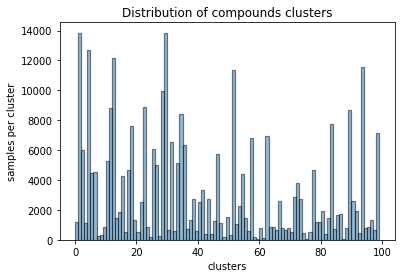

<Figure size 432x288 with 0 Axes>

In [49]:
# Histogram
bins = np.arange(0, 100, 1) # fixed bin size
plt.xlim([min(activity_df_clusters.loc[:,'cluster_label'])-5, max(activity_df_clusters.loc[:,'cluster_label'])+5])
plt.hist(activity_df_clusters['cluster_label'], bins=bins, alpha=0.5, edgecolor='black', linewidth=1.2)
plt.title('Distribution of compounds clusters')
plt.xlabel('clusters')
plt.ylabel('samples per cluster')
plt.show()
plt.savefig("".join((absPath, "data/", protein_type, "/resampling_before_clustering/preprocessing_figures/histogram_clusters.png")))

In [50]:
#we create nfolds differents splitting partitions
for i in range(nfolds):
    compounds_classif = accumulated_size_clusters(activity_df_clusters)
    compounds_classif = training_test_split(compounds_classif, 80, 10, 10, i)
    #Joining smiles-label dataframe with label information dataframe
    name_column = "splitting_" + str(i)
    activity_df_clusters = pd.merge(compounds_classif.loc[:, ["cluster_label", name_column]], 
                                 activity_df_clusters, on="cluster_label")

In [51]:
#Checking that all the partitions are more or less the same size
for i in range(nfolds):
    name_column = "splitting_" + str(i)
    print(activity_df_clusters[name_column].value_counts())

0    244072
2     36347
1     27493
Name: splitting_0, dtype: int64
0    243984
2     32602
1     31326
Name: splitting_1, dtype: int64
0    235834
2     38850
1     33228
Name: splitting_2, dtype: int64
0    241078
2     34537
1     32297
Name: splitting_3, dtype: int64
0    242848
1     32579
2     32485
Name: splitting_4, dtype: int64
0    242414
1     34598
2     30900
Name: splitting_5, dtype: int64
0    242743
2     33046
1     32123
Name: splitting_6, dtype: int64
0    245191
2     39858
1     22863
Name: splitting_7, dtype: int64
0    237067
1     35437
2     35408
Name: splitting_8, dtype: int64
0    245416
2     35238
1     27258
Name: splitting_9, dtype: int64


In [52]:
activity_df_clusters.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307912 entries, 0 to 307911
Columns: 896 entries, cluster_label to comp_ID
dtypes: float64(1), int64(892), object(3)
memory usage: 2.1+ GB


In [53]:
#Now we should check number of actives/inactives per splitting fold
count_list = []
for i in range(nfolds):
    name_column = "splitting_" + str(i)
    count_split = activity_df_clusters.loc[:,[name_column, "Y"]].groupby([name_column, 
                                          "Y"]).size().unstack(fill_value=0)
    count_split_df = pd.DataFrame(count_split)
    count_split_df_melt = pd.melt(count_split_df.reset_index(), id_vars = name_column, value_vars=[0.0,1.0])
    count_split_df_melt["splitting_fold"] = name_column
    count_split_df_melt = count_split_df_melt.rename(columns = {name_column:"split_set"})
    print(count_split)
    count_list.append(count_split_df_melt)

Y               0.0     1.0
splitting_0                
0            123735  120337
1             12416   15077
2             17805   18542
Y               0.0     1.0
splitting_1                
0            120810  123174
1             16886   14440
2             16260   16342
Y               0.0     1.0
splitting_2                
0            116113  119721
1             16071   17157
2             21772   17078
Y               0.0     1.0
splitting_3                
0            122133  118945
1             15660   16637
2             16163   18374
Y               0.0     1.0
splitting_4                
0            122273  120575
1             14660   17919
2             17023   15462
Y               0.0     1.0
splitting_5                
0            122382  120032
1             17274   17324
2             14300   16600
Y               0.0     1.0
splitting_6                
0            121373  121370
1             17147   14976
2             15436   17610
Y               0.0 

In [54]:
#preparing dataframe to check labels distribution across splitting sets    
count_list_df = pd.concat(count_list, axis=0)
vals_to_replace = {0:'training_set', 1:'validation_set', 2:'test_set'}
vals_to_replace2 = dict(zip(["splitting_"+str(i) for i in range(nfolds)], range(nfolds)))
count_list_df['split_set'] = count_list_df['split_set'].map(vals_to_replace)
count_list_df['splitting_fold'] = count_list_df['splitting_fold'].map(vals_to_replace2)

In [55]:
p = (ggplot(count_list_df, aes(y="value")) + 
 geom_bar(aes(x="factor(splitting_fold)", fill="Y"), stat="identity") + 
 facet_grid(".~split_set") + xlab("splitting fold") + ylab("number of compounds")+
 theme(legend_title=element_blank()))
p

ggsave(filename="".join((absPath, "data/", protein_type, "/resampling_before_clustering/preprocessing_figures/activity_distribution_clusters.pdf")), plot=p, dpi=300)

/home/angela3/venv/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/angela3/venv/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /home/angela3/imbalance_pcm_benchmark/data/GPCRs/resampling_before_clustering/preprocessing_figures/activity_distribution_clusters.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)


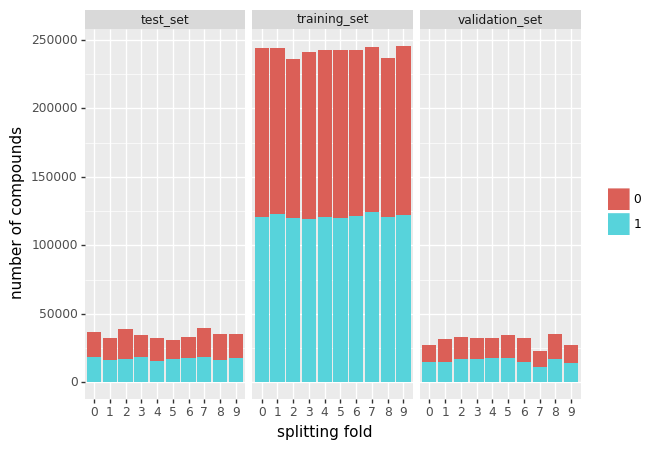

<ggplot: (8758596615025)>

In [56]:
p

In [57]:
#Now we should check coincidence between clusters in splitting folds
cluster_labels_list = []
for i in range(nfolds):
    cluster_labels = {}
    name_column = "splitting_" + str(i)
    count_split_cluster = activity_df_clusters.loc[:,[name_column, "cluster_label"]].groupby([name_column, 
                                          "cluster_label"]).size().unstack(fill_value=0)
    #binarizing
    binary_df = count_split_cluster >0
    cluster_lists = binary_df.apply(lambda x: binary_df.columns[x == True], axis=1)
    for idx in range(len(cluster_lists)):
        cluster_labels[idx] = list(cluster_lists[idx])
    cluster_labels_list.append(cluster_labels)
    #print(count_split_cluster)

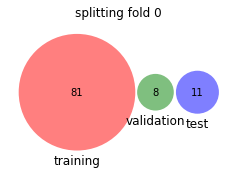

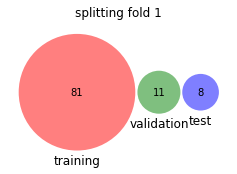

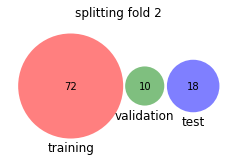

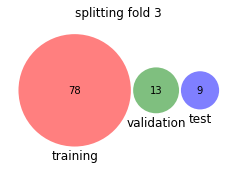

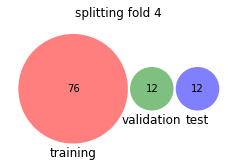

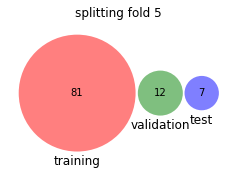

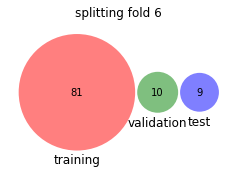

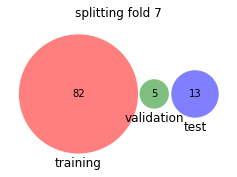

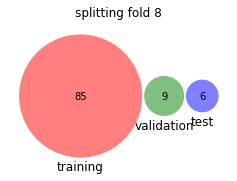

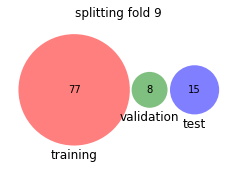

In [58]:
# Now we compute sets for drawing venn diagrams
for i in range(nfolds):
    len_train = len(cluster_labels_list[i][0])
    len_val = len(cluster_labels_list[i][1])
    len_test = len(cluster_labels_list[i][2])
    len_train_val =  len(set(cluster_labels_list[i][0]). intersection(set(cluster_labels_list[i][1])))
    len_train_test = len(set(cluster_labels_list[i][0]). intersection(set(cluster_labels_list[i][2])))
    len_val_test = len(set(cluster_labels_list[i][1]). intersection(set(cluster_labels_list[i][2])))
    len_train_val_test = len(set(cluster_labels_list[i][0]). intersection(set(cluster_labels_list[i][1])).intersection(set(cluster_labels_list[i][2])))
    plt.figure(figsize=(4,4))
    venn3(subsets = (len_train, len_val, len_train_val, len_test,  len_train_test, len_val_test, len_train_val_test),
          set_labels = ("training", "validation", "test"), alpha = 0.5)
    plt.title("splitting fold " + str(i))
    plt.savefig("".join((absPath, "data/", protein_type, "/resampling_before_clustering/preprocessing_figures/venn_clusters_", str(i), ".png")))

In [59]:
#falta la info de las secuencias, uniprot ID, prot_family

activity_file = "".join((absPath, "data/", protein_type, "_activity.csv"))
activity_df = pd.read_csv(activity_file, sep="\t")
print(activity_df.info())
print(activity_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200523 entries, 0 to 200522
Data columns (total 10 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Unnamed: 0                200523 non-null  int64  
 1   DeepAffinity Protein ID   200523 non-null  object 
 2   Uniprot ID                200523 non-null  object 
 3   DeepAffinity Compound ID  200523 non-null  object 
 4   CID                       200523 non-null  int64  
 5   activity                  200523 non-null  float64
 6   label                     200523 non-null  float64
 7   Canonical SMILE           200523 non-null  object 
 8   Sequence                  200523 non-null  object 
 9   family                    200523 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 15.3+ MB
None
   Unnamed: 0 DeepAffinity Protein ID Uniprot ID DeepAffinity Compound ID  \
0          32                    UYMO     Q92847                     4vb

In [60]:
unique_prots_df = activity_df[activity_df["DeepAffinity Protein ID"].isin(unique_prots)].drop_duplicates(["DeepAffinity Protein ID"])
unique_prots_df = unique_prots_df[["DeepAffinity Protein ID", "Uniprot ID", "Sequence", "family"]]
unique_prots_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 498 entries, 0 to 200522
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   DeepAffinity Protein ID  498 non-null    object
 1   Uniprot ID               498 non-null    object
 2   Sequence                 498 non-null    object
 3   family                   498 non-null    object
dtypes: object(4)
memory usage: 19.5+ KB


In [61]:
activity_df_clusters.rename(columns={"prot": "DeepAffinity Protein ID"}, inplace=True)

In [62]:
activity_df_clusters.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307912 entries, 0 to 307911
Columns: 896 entries, cluster_label to comp_ID
dtypes: float64(1), int64(892), object(3)
memory usage: 2.1+ GB


In [63]:
activity_clusters_prot_info = pd.merge(activity_df_clusters, 
                                       unique_prots_df, 
                                       "left", on=["DeepAffinity Protein ID"])
print(activity_clusters_prot_info.info())
print(activity_clusters_prot_info.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307912 entries, 0 to 307911
Columns: 899 entries, cluster_label to family
dtypes: float64(1), int64(892), object(6)
memory usage: 2.1+ GB
None
   cluster_label  splitting_9  splitting_8  splitting_7  splitting_6  \
0             96            0            0            0            0   
1             96            0            0            0            0   
2             96            0            0            0            0   
3             96            0            0            0            0   
4             96            0            0            0            0   

   splitting_5  splitting_4  splitting_3  splitting_2  splitting_1  ...  875  \
0            0            0            0            2            0  ...    0   
1            0            0            0            2            0  ...    0   
2            0            0            0            2            0  ...    0   
3            0            0            0            2 

In [64]:
#despues de dividir en training, test y validation 
#saving data into a HDF5
#Defining HDF5 table-type for storing data
class Protein_Compound_Complex(IsDescription):
    #CID = UInt16Col()
    da_comp_id = StringCol(4) 
    da_prot_id = StringCol(4)
    uniprot_id = StringCol(6)
    #activity = Float16Col()
    label = UInt16Col()
    #canonical_smiles = StringCol(100)
    sequence = StringCol(2000)
    prot_family = StringCol(5)
    comp_cluster = UInt16Col()
    splitting_0 = UInt8Col()
    splitting_1 = UInt8Col()
    splitting_2 = UInt8Col()
    splitting_3 = UInt8Col()
    splitting_4 = UInt8Col()
    splitting_5 = UInt8Col()
    splitting_6 = UInt8Col()
    splitting_7 = UInt8Col()
    splitting_8 = UInt8Col()
    splitting_9 = UInt8Col()
    fingerprint = StringCol(900)
    
#open a HDF5 file with write options
file_h5 = open_file("".join((absPath, "data/", protein_type,"/resampling_before_clustering/compounds_activity.h5")), "w")
root = file_h5.root
group = file_h5.create_group(root, "activity")
table = file_h5.create_table('/activity', "prot_comp", Protein_Compound_Complex) 
pair = table.row

for index,row in activity_clusters_prot_info.iterrows():
    #pair["CID"] = row["CID"]
    pair["da_comp_id"] = row["comp_ID"]
    pair["da_prot_id"] = row["DeepAffinity Protein ID"]
    pair["uniprot_id"] = row["Uniprot ID"]
    #pair["activity"] = row["activity"]
    pair["label"] = row["Y"]
    #pair["canonical_smiles"] = row["Canonical SMILE"]
    pair["sequence"] = row["Sequence"]
    pair["prot_family"] = row["family"]
    pair["comp_cluster"] = row["cluster_label"]
    pair["fingerprint"] = row["fingerprint"]
    for i in range(nfolds):
        name_col = "splitting_" + str(i)
        pair[name_col] = row[name_col]
    pair.append()
table.flush()
file_h5.close()

In [65]:
#Opening HDF5 with data
filee = "".join((absPath, "data/", protein_type,"/resampling_before_clustering/compounds_activity.h5"))
f = h5py.File(filee, 'r')
group = '/activity'
table = "prot_comp"
#shuffling data indices
n_samples = len(f[group][table])
sample_indices = np.arange(0, n_samples)
sample_indices = np.random.permutation(sample_indices)

In [67]:
#creating folder to storage splitting lists if it does not exist
if not os.path.exists("".join((absPath, "data/", protein_type, "/resampling_before_clustering/splitting_lists/"))):
    os.makedirs("".join((absPath, "data/", protein_type, "/resampling_before_clustering/splitting_lists/")))

In [68]:
for i in range(nfolds):
    column_name = "splitting_" + str(i)
    training_list, validation_list, test_list = splitting_division(f, group, 
                                                                   table, 
                                                                   sample_indices, 
                                                                   column_name)
    
    pickle_filename = "".join((absPath, "data/", protein_type, "/resampling_before_clustering/splitting_lists/",
                               column_name, "_list.pickle"))
    with open(pickle_filename, "wb") as handle:
        pickle.dump((training_list, validation_list, test_list), handle)

1872.2179718017578
615.6954710483551
680.0064980983734
559.6375620365143
487.1790130138397
485.2479581832886
486.0680797100067
563.3454144001007
459.3427848815918
460.0402252674103
